In [1]:
import sys, time, pickle
from pyspark import SparkContext, SparkConf
from pyspark.sql import *
from pyspark.sql.types import *
from IPython.core.display import display, HTML
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import ClusteringEvaluator
import pandas as pd
import numpy as np

from sklearn.feature_selection import mutual_info_regression

import matplotlib.pyplot as plt

# make matplotlib plot sizes larger
plt.rcParams['figure.figsize'] = [30, 20]

conf = SparkConf().setAppName('Steam Random Forest Regressor').setMaster('spark://sparkmaster:7077')
SparkContext.setSystemProperty('spark.executor.memory', '2g') # memory per executor
SparkContext.setSystemProperty('spark.executor.cores', '6') # cores per executor
SparkContext.setSystemProperty('spark.executor.instances', '3') # per worker (computer)

# https://spark.apache.org/docs/3.0.0-preview/configuration.html#dynamic-allocation
# https://stackoverflow.com/questions/26168254/how-to-set-amount-of-spark-executors
# https://blog.cloudera.com/how-to-tune-your-apache-spark-jobs-part-2/

# SparkContext.setSystemProperty("spark.shuffle.service.enabled", "True") # required for dynamic allocation below
# SparkContext.setSystemProperty("spark.dynamicAllocation.enabled", "True")
# SparkContext.setSystemProperty("spark.executor.cores", "4")
# SparkContext.setSystemProperty("spark.dynamicAllocation.minExecutors", "1")
# SparkContext.setSystemProperty("spark.dynamicAllocation.maxExecutors", "5")
# SparkContext.setSystemProperty('spark.executor.memory', '2g') # memory per executor

sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)

In [2]:
sc._conf.getAll()

[('spark.executor.memory', '2g'),
 ('spark.driver.host', 'jupyterlab'),
 ('spark.executor.instances', '3'),
 ('spark.app.name', 'Steam Random Forest Regressor'),
 ('spark.executor.id', 'driver'),
 ('spark.app.id', 'app-20210629212749-0008'),
 ('spark.master', 'spark://sparkmaster:7077'),
 ('spark.driver.port', '41671'),
 ('spark.executor.cores', '6'),
 ('spark.app.startTime', '1625023668742'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

In [3]:
df = pickle.load(open("df.p", "rb"))
feature_list = pickle.load(open("feature_list.p", "rb"))

In [4]:
assembler = VectorAssembler(inputCols=feature_list, outputCol="features")

In [5]:
rf = RandomForestRegressor(labelCol="days_until_discount", featuresCol="features")
gbt = GBTRegressor(labelCol="days_until_discount", featuresCol="features")
lr = LinearRegression(labelCol="days_until_discount", featuresCol="features")

pipeline = Pipeline(stages=[assembler, rf])
gbt_pipeline = Pipeline(stages=[assembler, gbt])
linear_pipeline = Pipeline(stages=[assembler, lr])

In [6]:
# TODO: tweak these parameters more

# Random Forest
paramGrid = ParamGridBuilder() \
.addGrid(rf.numTrees, [int(x) for x in np.linspace(start=10, stop=200, num=8)]) \
.addGrid(rf.maxDepth, [int(x) for x in np.linspace(start=1, stop=20, num=8)]) \
.build()
#.addGrid(rf.maxBins, ?) \ # should this also be set?

# Gradient Boosted Tree
gbt_paramGrid = ParamGridBuilder() \
.addGrid(gbt.maxIter, [int(x) for x in np.linspace(start=5, stop=25, num=2)]) \
.addGrid(gbt.maxDepth, [int(x) for x in np.linspace(start=1, stop=20, num=8)]) \
.build()
#.addGrid(gbt.maxBins, ?) \ # should this also be set?

# Linear Regression
linear_paramGrid = ParamGridBuilder() \
.addGrid(lr.regParam, [0.1, 0.01]) \
.addGrid(lr.fitIntercept, [False, True]) \
.addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
.build()

In [7]:
evaluator = RegressionEvaluator().setLabelCol("days_until_discount")

crossval = CrossValidator(estimator=pipeline,
                         estimatorParamMaps=paramGrid,
                         evaluator=evaluator,
                         numFolds=3)

gbt_crossval = CrossValidator(estimator=gbt_pipeline,
                         estimatorParamMaps=gbt_paramGrid,
                         evaluator=evaluator,
                         numFolds=3)

linear_crossval = CrossValidator(estimator=linear_pipeline,
                         estimatorParamMaps=linear_paramGrid,
                         evaluator=evaluator,
                         numFolds=3)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1354 entries, 329 to 75060
Data columns (total 65 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   type                      1354 non-null   object        
 1   name                      1354 non-null   object        
 2   required_age              1354 non-null   int64         
 3   appid                     1354 non-null   int64         
 4   release_date              1354 non-null   datetime64[ns]
 5   initial_price             1354 non-null   float64       
 6   metacritic_score          1354 non-null   float64       
 7   windows                   1354 non-null   bool          
 8   mac                       1354 non-null   bool          
 9   linux                     1354 non-null   bool          
 10  publisher                 1354 non-null   object        
 11  developer                 1354 non-null   object        
 12  number_dlc       

In [9]:
trainingData = df.sample(frac=0.8)
testData = df.drop(trainingData.index)

In [10]:
# https://stackoverflow.com/questions/37513355/converting-pandas-dataframe-into-spark-dataframe-error
schema = StructType([ StructField("type", StringType(), True)\
                       ,StructField("name", StringType(), True)\
                       ,StructField("required_age", IntegerType(), True)\
                       ,StructField("appid", IntegerType(), True)\
                       ,StructField("release_date", DateType(), True)\
                       ,StructField("initial_price", DoubleType(), True)\
                       ,StructField("metacritic_score", DoubleType(), True)\
                       ,StructField("windows", BooleanType(), True)\
                       ,StructField("mac", BooleanType(), True)\
                       ,StructField("linux", BooleanType(), True)\
                       ,StructField("publisher", StringType(), True)\
                       ,StructField("developer", StringType(), True)\
                       ,StructField("number_dlc", IntegerType(), True)\
                       ,StructField("number_genres", IntegerType(), True)\
                       ,StructField("number_categories", IntegerType(), True)\
                       ,StructField("total_recommendations", DoubleType(), True)\
                       ,StructField("release_day_in_year", DoubleType(), True)\
                       ,StructField("sum_recommendations_up", DoubleType(), True)\
                       ,StructField("sum_recommendations_down", DoubleType(), True)\
                       ,StructField("date", DateType(), True)\
                       ,StructField("days_until_discount", DoubleType(), True)\
                       ,StructField("start_players_-1", DoubleType(), True)\
                       ,StructField("start_players_0", DoubleType(), True)\
                       ,StructField("start_players_1", DoubleType(), True)\
                       ,StructField("start_players_2", DoubleType(), True)\
                       ,StructField("start_players_3", DoubleType(), True)\
                       ,StructField("start_players_4", DoubleType(), True)\
                       ,StructField("start_players_5", DoubleType(), True)\
                       ,StructField("start_twitch_viewers_-1", DoubleType(), True)\
                       ,StructField("start_twitch_viewers_0", DoubleType(), True)\
                       ,StructField("start_twitch_viewers_1", DoubleType(), True)\
                       ,StructField("start_twitch_viewers_2", DoubleType(), True)\
                       ,StructField("start_twitch_viewers_3", DoubleType(), True)\
                       ,StructField("start_twitch_viewers_4", DoubleType(), True)\
                       ,StructField("start_twitch_viewers_5", DoubleType(), True)\
                       ,StructField("start_twitch_rank_-1", DoubleType(), True)\
                       ,StructField("start_twitch_rank_0", DoubleType(), True)\
                       ,StructField("start_twitch_rank_1", DoubleType(), True)\
                       ,StructField("start_twitch_rank_2", DoubleType(), True)\
                       ,StructField("start_twitch_rank_3", DoubleType(), True)\
                       ,StructField("start_twitch_rank_4", DoubleType(), True)\
                       ,StructField("start_twitch_rank_5", DoubleType(), True)\
                       ,StructField("hasLootBoxes", StringType(), True)\
                       ,StructField("isMajorTitle", StringType(), True)\
                       ,StructField("medianScore", DoubleType(), True)\
                       ,StructField("numReviews", DoubleType(), True)\
                       ,StructField("numTopCriticReviews", DoubleType(), True)\
                       ,StructField("percentRecommended", DoubleType(), True)\
                       ,StructField("percentile", DoubleType(), True)\
                       ,StructField("tier", StringType(), True)\
                       ,StructField("topCriticScore", DoubleType(), True)\
                       ,StructField("game_type", StringType(), True)\
                       ,StructField("number_platforms", DoubleType(), True)\
                       ,StructField("number_skus", DoubleType(), True)\
                       ,StructField("type_num", IntegerType(), True)\
                       ,StructField("hasLootBoxes_num", IntegerType(), True)\
                       ,StructField("isMajorTitle_num", IntegerType(), True)\
                       ,StructField("tier_num", IntegerType(), True)\
                       ,StructField("game_type_num", IntegerType(), True)\
                       ,StructField("windows_num", IntegerType(), True)\
                       ,StructField("mac_num", IntegerType(), True)\
                       ,StructField("linux_num", IntegerType(), True)\
                       ,StructField("developer_num", IntegerType(), True)\
                       ,StructField("publisher_num", IntegerType(), True)\
                       ,StructField("cluster_prediction", IntegerType(), True)])

In [11]:
# convert pandas dataframe to spark dataframe
trainingData = sqlContext.createDataFrame(trainingData, schema=schema)
testData = sqlContext.createDataFrame(testData, schema=schema)

In [12]:
trainingData.summary().show()

+-------+----+--------------------+------------------+------------------+------------------+-----------------+---------+------------------+------------------+------------------+------------------+---------------------+-------------------+----------------------+------------------------+-------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------+------------+------------------+------------------+-------------------+------------------+------------------+----+------------------+---------+------------------+-----------------+--------------------+--------------------+------------------+-----

In [13]:
trainingData.head()

Row(type='game', name='RAID: World War II', required_age=17, appid=414740, release_date=datetime.date(2017, 9, 26), initial_price=1999.0, metacritic_score=53.0, windows=True, mac=False, linux=False, publisher='Starbreeze Publishing AB', developer='Lion game Lion', number_dlc=3, number_genres=3, number_categories=9, total_recommendations=1558.0, release_day_in_year=269.0, sum_recommendations_up=893.0, sum_recommendations_down=763.0, date=datetime.date(2018, 11, 22), days_until_discount=422.02140748842595, start_players_-1=0.0, start_players_0=0.0, start_players_1=0.0, start_players_2=0.0, start_players_3=0.0, start_players_4=0.0, start_players_5=0.0, start_twitch_viewers_-1=0.0, start_twitch_viewers_0=0.0, start_twitch_viewers_1=0.0, start_twitch_viewers_2=0.0, start_twitch_viewers_3=0.0, start_twitch_viewers_4=0.0, start_twitch_viewers_5=0.0, start_twitch_rank_-1=0.0, start_twitch_rank_0=0.0, start_twitch_rank_1=0.0, start_twitch_rank_2=0.0, start_twitch_rank_3=0.0, start_twitch_rank_4

In [14]:
testData.summary().show()

+-------+----+-------+------------------+------------------+------------------+-----------------+---------+----------+-----------------+------------------+-----------------+---------------------+-------------------+----------------------+------------------------+-------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+-----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------+------------+-----------------+-----------------+-------------------+------------------+-----------------+----+-----------------+---------+------------------+------------------+--------------------+--------------------+-------------------+------------------+-------------

In [15]:
testData.head()

Row(type='game', name='Wartile', required_age=0, appid=404200, release_date=datetime.date(2018, 2, 8), initial_price=1999.0, metacritic_score=68.0, windows=True, mac=False, linux=False, publisher='Deck13', developer='Playwood Project', number_dlc=2, number_genres=2, number_categories=5, total_recommendations=484.0, release_day_in_year=39.0, sum_recommendations_up=383.0, sum_recommendations_down=107.0, date=datetime.date(2018, 9, 15), days_until_discount=219.82702239583332, start_players_-1=0.0, start_players_0=0.0, start_players_1=0.0, start_players_2=0.0, start_players_3=0.0, start_players_4=0.0, start_players_5=0.0, start_twitch_viewers_-1=0.0, start_twitch_viewers_0=0.0, start_twitch_viewers_1=0.0, start_twitch_viewers_2=0.0, start_twitch_viewers_3=0.0, start_twitch_viewers_4=0.0, start_twitch_viewers_5=0.0, start_twitch_rank_-1=0.0, start_twitch_rank_0=0.0, start_twitch_rank_1=0.0, start_twitch_rank_2=0.0, start_twitch_rank_3=0.0, start_twitch_rank_4=0.0, start_twitch_rank_5=0.0, h

In [16]:
# TODO: look into partitions
# https://luminousmen.com/post/spark-partitions
# https://www.dezyre.com/article/how-data-partitioning-in-spark-helps-achieve-more-parallelism/297



In [17]:
# calculate mutual information
# https://www.kaggle.com/ryanholbrook/mutual-information

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

integer_df = df.select_dtypes(include=['int', 'float'])

X = integer_df.copy()
X.pop("appid")
y = X.pop("days_until_discount")

discrete_features = X.dtypes == int

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::2]

release_day_in_year         0.842100
publisher_num               0.165107
initial_price               0.065609
start_players_0             0.044262
mac_num                     0.035633
start_twitch_viewers_0      0.032900
start_twitch_rank_0         0.031808
start_twitch_rank_-1        0.031033
start_players_3             0.027945
sum_recommendations_up      0.026831
start_twitch_rank_3         0.025827
start_twitch_viewers_3      0.025486
isMajorTitle_num            0.024524
tier_num                    0.024405
sum_recommendations_down    0.023503
total_recommendations       0.022225
start_twitch_rank_2         0.020783
start_twitch_rank_5         0.019048
number_genres               0.018362
start_twitch_viewers_5      0.018004
medianScore                 0.006764
metacritic_score            0.001371
type_num                    0.000000
game_type_num               0.000000
percentRecommended          0.000000
Name: MI Scores, dtype: float64

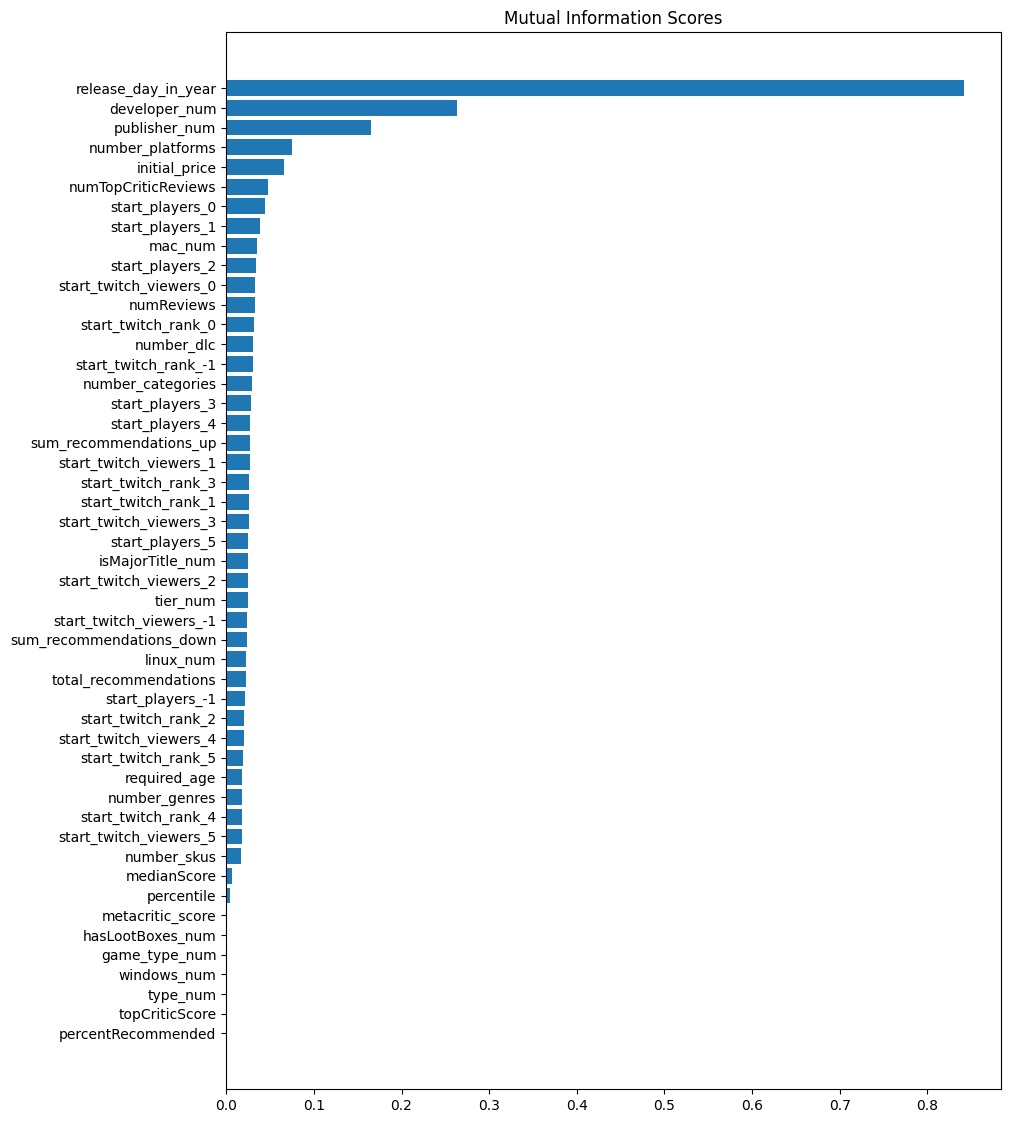

In [18]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(10, 14))
plot_mi_scores(mi_scores)

In [19]:
mi_scores.head(n=20)

release_day_in_year       0.842100
developer_num             0.262890
publisher_num             0.165107
number_platforms          0.074592
initial_price             0.065609
numTopCriticReviews       0.047599
start_players_0           0.044262
start_players_1           0.038588
mac_num                   0.035633
start_players_2           0.034212
start_twitch_viewers_0    0.032900
numReviews                0.032413
start_twitch_rank_0       0.031808
number_dlc                0.031034
start_twitch_rank_-1      0.031033
number_categories         0.029918
start_players_3           0.027945
start_players_4           0.026950
sum_recommendations_up    0.026831
start_twitch_viewers_1    0.026663
Name: MI Scores, dtype: float64

In [20]:
starttime = time.time()
cvModel = crossval.fit(trainingData)
endtime = time.time()

print("Random Forest Training took: " + str((endtime-starttime)/60) + " minutes")

cvModel.write().overwrite().save("/work/steam-randomforest-model")

KeyboardInterrupt: 

In [ ]:
starttime = time.time()
gbt_model = gbt_crossval.fit(trainingData)
endtime = time.time()

print("Gradient Boosted Tree Training took: " + str((endtime-starttime)/60) + " minutes")

gbt_model.write().overwrite().save("/work/steam-gbt-model")

In [ ]:
starttime = time.time()
linear_model = linear_crossval.fit(trainingData)
endtime = time.time()

print("Linear Regression Training took: " + str((endtime-starttime)/60) + " minutes")

linear_model.write().overwrite().save("/work/steam-linear-model")

In [ ]:
predictions = cvModel.transform(testData)
gbt_predictions = gbt_model.transform(testData)
linear_predictions = linear_model.transform(testData)

In [ ]:
# persist and serialize objects to disk for next step
pickle.dump(predictions, open("/work/predictions.p", "wb"))
pickle.dump(gbt_predictions, open("/work/gbt_predictions.p", "wb"))
pickle.dump(linear_predictions, open("/work/linear_predictions.p", "wb"))

In [ ]:
sc.stop()